In [1]:
import json
import zipfile

username = 'lexa77'
key = 'dda13443765b5ceb96e5f4e35d10835e'

API_KEY = {"username":username,"key":key}

with open('kaggle.json', 'w') as outfile:
  json.dump(API_KEY, outfile)

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
%%capture
!pip install -q kaggle
!pip install -q kaggle-cli

In [4]:
!kaggle competitions download -c dogs-vs-cats

 99% 540M/543M [00:03<00:00, 193MB/s]
100% 543M/543M [00:03<00:00, 159MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 88.9MB/s]
 93% 252M/271M [00:01<00:00, 150MB/s]
100% 271M/271M [00:01<00:00, 148MB/s]


In [5]:
#Unzip files

train_zip = '/content/train.zip'
train_dir = '/content/train'

test_zip = '/content/test1.zip'
test_dir = '/content/test'


with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall(train_dir)


with zipfile.ZipFile(test_zip, 'r') as zip_ref:
    zip_ref.extractall(test_dir)

In [1]:
import os

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

## Define tranformations and Custom Dataset ##

In [2]:
# Define a set of transformations to perform. Have to convert np array to a PyTorch Tensor. We then proceed to normalize it

transform = transforms.Compose([
                                # Convert to Tensor
                                transforms.ToTensor(),
                                # Normalize. Provide the mean and std. across the 3 color channels
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
# Define a custom dataset.
# __getitem__ is the function that pytorch uses for retreiving the dataset.

class ImgDataset(Dataset):
  def __init__(self, imgs, labels, transform=None):
    self.imgs = imgs
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  # Idx will be populated by pytorch automatically
  # Pytorch uses this function to retrieve examples
  def __getitem__(self, idx):
    sample = self.imgs[idx]
    if self.transform:
      sample = self.transform(sample)
    
    return (sample, self.labels[idx])

##Choosing Ideal shape for our images##

In [12]:
shapes = []

for img_name in os.listdir(train_dir):
  path = train_dir + '/' + img_name
  img = Image.open(path)
  img = np.array(img)
  shapes.append(img.shape)

In [ ]:
# Get the smallest dim size for dim 1
min_d1 = min([i[0] for i in shapes])
print(min_d1)

In [19]:
# Get the smallest dim size for dim 2
min_d2 = min([i[1] for i in shapes])
print(min_d2)

42


In [20]:
# Get the smallest dim size for dim 3. Here, we see that all are of size 3 (Are RGB colored)
min_d3 = min([i[2] for i in shapes])
print(min_d3)

3


In [61]:
less_w = 0
less_h = 0

for img_name in os.listdir(train_dir):
  path = train_dir + '/' + img_name
  img = Image.open(path)
  img_arr = np.array(img)
  if img_arr.shape[0] < 50:
    less_w += 1
  if img_arr.shape[1] < 50:
    less_h += 1

IndexError: ignored

In [ ]:
print(less_w)
print(less_h)

##Preprocess the dataset##

In [5]:
train_dir = '/content/train/train'

NEW_SHAPE = (50,50)
imgs = []
labels = []
less_w = 0
less_h = 0

for img_name in os.listdir(train_dir):
  path = train_dir + '/' + img_name
  img = Image.open(path)
  shape = img.size
  # Only keep if the sizes is > (50 x 50)
  if shape[0] <50 or shape[1] < 50:
    continue
  img = img.resize(NEW_SHAPE)
  img_arr = np.array(img)
  imgs.append(img_arr)
  if img_name.startswith('cat'):
    labels.append(0)
  elif img_name.startswith('dog'):
    labels.append(1)
  else:
    raise Exception(f'Received error from {img_name}')

In [6]:
# As can be seen, some images have been taken out
imgs_np = np.array(imgs)
labels_np = np.array(labels)

print(imgs_np.shape)
print(labels_np.shape)

(24982, 50, 50, 3)
(24982,)


## Create the pytorch dataset##

In [7]:
# Split between the training and testing sets
train_val_dataset = ImgDataset(imgs_np, labels_np, transform)

In [9]:
# Split between the validation and training sets

train_size = 20000
val_size = len(labels_np)-train_size

train_set, val_set = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

In [10]:
# You use pytorch's DataLoader class for the final training. Here, you pass in your custom dataset class to pytorch's DataLoader

BATCH_SIZE = 32
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

##Build Model##

In [11]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [12]:
def conv_block(input_dim, n_filters, *args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(input_dim, n_filters, *args, **kwargs),
        nn.ReLU()
    )

In [13]:
class CNN(nn.Module):
  def __init__(self, input_channels, output_dim):
    super().__init__()
    self.input_channels = input_channels
    self.output_dim = output_dim
    self.cnn_model = nn.Sequential(
        conv_block(input_channels, 10, kernel_size=5),
        # Kernel size (2x2) and stride 2
        nn.MaxPool2d(2,2),
        conv_block(10, 16, kernel_size=5),
        nn.MaxPool2d(2,2)
    )

    self.hidden_model = nn.Sequential(
        # Input dim is decided by looking at summary (Final conv2d layer has shape [-1, 16, 9, 9] as output)
        nn.Linear(16*9*9, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.cnn_model(x)
    # Flatten the output. Basically, you keep the batch size (32 in this case) and flatten the other dimensions to just become one dimension (As seen with -1)
    # Here, you flatten from (32, 16, 9, 9) to (32, 128)
    x = x.view(x.size(0), -1)
    x = self.hidden_model(x)

    return x

  def get_conv_model(self):
    return self.cnn_model

##Model Summaries##

In [37]:
# DO this to find the output shape of the CNN. Then, we can use this shape to build the LinearLayer
# -1 represents the batch_size (32 in this case)

cnn_model = CNN(3, 1).get_conv_model()
cnn_model.cuda()

summary(cnn_model, (3,50,50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 46, 46]             760
              ReLU-2           [-1, 10, 46, 46]               0
         MaxPool2d-3           [-1, 10, 23, 23]               0
            Conv2d-4           [-1, 16, 19, 19]           4,016
              ReLU-5           [-1, 16, 19, 19]               0
         MaxPool2d-6             [-1, 16, 9, 9]               0
Total params: 4,776
Trainable params: 4,776
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.46
Params size (MB): 0.02
Estimated Total Size (MB): 0.51
----------------------------------------------------------------


In [50]:
model = CNN(3,1)
# Must do model.cuda() to make it GPU device. Will send the weights to GPU
model.cuda()

summary(model, (3,50,50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 46, 46]             760
              ReLU-2           [-1, 10, 46, 46]               0
         MaxPool2d-3           [-1, 10, 23, 23]               0
            Conv2d-4           [-1, 16, 19, 19]           4,016
              ReLU-5           [-1, 16, 19, 19]               0
         MaxPool2d-6             [-1, 16, 9, 9]               0
            Linear-7                  [-1, 128]         166,016
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 64]           8,256
             ReLU-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
          Sigmoid-12                    [-1, 1]               0
Total params: 179,113
Trainable params: 179,113
Non-trainable params: 0
-------------------------------

## Training Configs##

In [16]:
model = CNN(3,1)
model.cuda()

CNN(
  (cnn_model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(10, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden_model): Sequential(
    (0): Linear(in_features=1296, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [17]:
# Set to GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
# Use binary cross entropy loss with Adam opt

import torch.optim as optim

loss_f = nn.BCELoss().to(device)
opt = optim.Adam(model.parameters(), lr=0.0005)

In [19]:
# Evaluation function. We round all the sigmoid outputs to 0/1 and measure its accuracy 

def evaluate(dataloader):
  for imgs, labels in dataloader:
    imgs, labels = data
    imgs, labels = imgs.to(device), labels.to(device)
    # Make the labels have the same shape as the outputs
    labels = labels.unsqueeze(1).float()
    output = model(imgs)
    pred = torch.round(output)
    # See if the preds equal to the labels
    correct = pred.eq(labels)
    acc = torch.mean(correct.float())
    return acc

## Training Loop##

In [20]:
EPOCHS = 20
train_acc_list = []
val_acc_list = []

for epoch in range(EPOCHS):
  for idx, data in enumerate(train_loader):
    imgs, labels = data
    imgs, labels = imgs.to(device), labels.to(device)
    opt.zero_grad()
    output = model(imgs)
    labels = labels.unsqueeze(1).float()
    loss = loss_f(output, labels)
    loss.backward()
    opt.step()

    # Evaluate
    if idx%500 == 0:
      pred = torch.round(output)
      correct = pred.eq(labels)
      acc = torch.mean(correct.float())
      train_acc_list.append(acc)
      print(f'Running at step {idx} at Accuracy {acc}')

      val_acc = evaluate(val_loader)
      val_acc_list.append(val_acc)
      print(f'Running at Epoch {epoch} with validation accuracy {val_acc}')

Running at step 0 at Accuracy 0.625
Running at Epoch 0 with validation accuracy 0.625
Running at step 500 at Accuracy 0.8125
Running at Epoch 0 with validation accuracy 0.8125
Running at step 0 at Accuracy 0.75
Running at Epoch 1 with validation accuracy 0.8125
Running at step 500 at Accuracy 0.6875
Running at Epoch 1 with validation accuracy 0.6875
Running at step 0 at Accuracy 0.71875
Running at Epoch 2 with validation accuracy 0.71875
Running at step 500 at Accuracy 0.9375
Running at Epoch 2 with validation accuracy 0.9375
Running at step 0 at Accuracy 0.875
Running at Epoch 3 with validation accuracy 0.8125
Running at step 500 at Accuracy 0.8125
Running at Epoch 3 with validation accuracy 0.84375
Running at step 0 at Accuracy 0.75
Running at Epoch 4 with validation accuracy 0.75
Running at step 500 at Accuracy 0.875
Running at Epoch 4 with validation accuracy 0.875
Running at step 0 at Accuracy 0.875
Running at Epoch 5 with validation accuracy 0.84375
Running at step 500 at Accurac

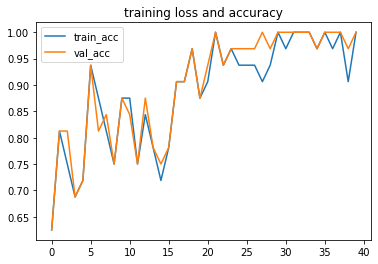

In [21]:
plt.plot(train_acc_list, label='train_acc')
plt.plot(val_acc_list, label='val_acc')
plt.legend()
plt.title('training loss and accuracy')
plt.show()

##Make predictions##

In [56]:
train_dir = '/content/test/test1'

NEW_SHAPE = (50,50)
imgs = []
less_w = 0
less_h = 0

for img_name in os.listdir(train_dir):
  path = train_dir + '/' + img_name
  img = Image.open(path)
  shape = img.size
  # Only keep if the sizes is > (50 x 50)
  if shape[0] <50 or shape[1] < 50:
    continue
  img = img.resize(NEW_SHAPE)
  img_arr = np.array(img)
  imgs.append(img_arr)

In [57]:
imgs_np = np.array(imgs)
print(imgs_np.shape)

(12492, 50, 50, 3)


In [62]:
dataset = ImgDataset(imgs_np, np.zeros(len(imgs_np)), transform)
test_loader = DataLoader(dataset)

In [84]:
preds = []
for imgs, labels in test_loader:
  imgs = imgs.to(device)
  output = model(imgs)
  pred = torch.round(output)
  pred = pred.data[0,0].item()
  preds.append(pred)

In [88]:
# Convert all to integer
final_preds = list(map(lambda x: int(x), preds))

In [106]:
img_id = [i for i in range(1, len(final_preds)+1)]
df = pd.DataFrame({"label": final_preds}, index=img_id)
df.index.name = 'id'

In [107]:
df.head()

,label
id,
1,1
2,1
3,0
4,0
5,1


In [110]:
df.to_csv('final.csv')

In [112]:
!kaggle competitions submit -c dogs-vs-cats -f /content/final.csv -m "first"

100% 86.8k/86.8k [00:00<00:00, 414kB/s]
Could not find competition - please verify that you entered the correct competition ID and that the competition is still accepting submissions.
